# Investigate issue #182

https://github.com/mjhoptics/ray-optics/issues/182#issue-3238200443

In [1]:
%matplotlib inline
# use widget to enable interactive figures.
#%matplotlib widget

In [2]:
isdark = False

In [3]:
from rayoptics.environment import *

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from rayoptics.gui import dashboards
from rayoptics.mpl.interactivelayout import InteractiveLayout

In [5]:
import numpy as np
from rayoptics.optical.opticalmodel import OpticalModel
from rayoptics.raytr.trace import trace_ray
from rayoptics.raytr.waveabr import transfer_to_exit_pupil
from rayoptics.elem import surface as srf
from rayoptics.elem.profiles import YToroid
from rayoptics.raytr.opticalspec import PupilSpec, FieldSpec, WvlSpec
from rayoptics.optical import model_constants as mc


def compute_sin_theta(opm, u, v, fld, wvl, exp_dst_parax):
    # trace one marginal ray at pupil coord [u,v]
    ray_pkg, trace_err = trace_ray(opm, [u, v], fld, wvl, apply_vignetting=False)

    if trace_err:
        raise RuntimeError(f"Ray trace failed: {trace_err}")

    ray_list, _, _ = ray_pkg
    pt_exit, dir_exit, _, _ = ray_list[-1]
    ray_seg = (pt_exit, dir_exit)
    exp_pt, exp_dir, *_ = transfer_to_exit_pupil(last_interface, ray_seg, exp_dst_parax)
    return np.hypot(exp_dir[0], exp_dir[1])

## Create the optical model

In [6]:
# ----------------------------
# Optical Model Setup
# ----------------------------
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

# Set model properties
opm.radius_mode = True
sm.do_apertures = False

# Optical specifications
epd = 3.0
osp['pupil'] = PupilSpec(osp, key=['object', 'epd'], value=epd)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=0.0, flds=[0.0])
osp['wvls'] = WvlSpec([(546.074, 1.0)], ref_wl=0)

# Surface 0: Object
sm.gaps[0].thi = 1e100

# Surface 1: STOP (Pupil)
sm.add_surface([0.0, 0.0, 'Air'], sd=1.5)
sm.set_stop()

# Surface 2: YToroid Anterior
gamma_rot = 0.
#gamma_rot = 30.
sm.add_surface([18., 2., 1.5], sd=5.0)
sm.ifcs[sm.cur_surface].profile = YToroid(r=18.0, rR=20.0, cc=0.0)
sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('dec and return')
sm.ifcs[sm.cur_surface].decenter.euler = np.array([0., 0., gamma_rot])  # rotate 30° Z

# Surface 3: Spherical Posterior
sm.add_surface([-20., 0., 'Air'], sd=5.0)

opm.update_model()

# Optimize Img position using paraxial ray tracing
ar = opm['analysis_results']
ax_ray = ar['parax_data'].ax_ray
prx_img_dist = -ax_ray[-1][mc.ht] / ax_ray[-1][mc.slp]
sm.gaps[-1].thi = prx_img_dist
exp_dst = pm.sys[-1][1]  # Distance from image to exit pupil
last_interface = sm.ifcs[-1]  # Image plane interface

opm.update_model()

sm.list_model()

# Ray-trace
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)
exp_dst_parax = ar['parax_data'].fod.exp_dist


# Entrance-pupil radius in mm
epd = osp['pupil'].value
rp = epd / 2.0

n = 361
phis = np.linspace(0, 2 * np.pi, n)  # 1° sampling

sin_thetas = np.empty(n)
for i, phi in enumerate(phis):
    u = rp * np.cos(phi)
    v = rp * np.sin(phi)
    sin_thetas[i] = compute_sin_theta(opm, u, v, fld, wvl, exp_dst_parax)

# find max & min
i_max = np.argmax(sin_thetas)
i_min = np.argmin(sin_thetas)

phi_max = phis[i_max] * 180 / np.pi
phi_min = phis[i_min] * 180 / np.pi

sin_max = sin_thetas[i_max]
sin_min = sin_thetas[i_min]

wfno_max = 1 / (2 * sin_max)
wfno_min = 1 / (2 * sin_min)

              r            t        medium     mode   zdr      sd
  Obj:     0.000000 1.00000e+100       air      dummy  1      1.0000
 Stop:     0.000000      0.00000       air             1      1.5000
    2:    18.000000      2.00000   n:1.500             1      5.0000
    3:   -20.000000      18.5714       air             1      5.0000
  Img:     0.000000      0.00000                dummy  1      1.0000


In [7]:
print(f"{wfno_max=:6.3f}   {wfno_min=:6.3f}")

wfno_max= 4.230   wfno_min= 4.465


## Model listings

In [8]:
sm.list_sg()

               r               mode              type          y       alpha
                       t           medium
  Obj:      0.00000            dummy
                1.00000e+100          air
 Stop:      0.00000                 
                     0.00000          air
    2:      18.0000                      dec and return     0.0000     0.0000
                     2.00000      n:1.500
    3:     -20.0000                 
                     18.5714          air
  Img:      0.00000            dummy


In [9]:
pm.first_order_data()

efl               19.29
f                 19.29
f'                19.29
ffl              -18.64
pp1              0.6429
bfl               18.57
ppk             -0.7143
pp sep           0.6429
f/#               6.429
m              1.11e-16
red          -5.185e+98
obj_dist         1e+100
obj_ang               1
enp_dist             -0
enp_radius          1.5
na obj         1.5e-100
n obj                 1
img_dist          18.57
img_ht           0.3366
exp_dist         -1.379
exp_radius        1.552
na img         -0.07778
n img                 1
optical invariant      0.02618


In [10]:
set_vignetting(opm)

In [11]:
listobj(osp)

aperture: object epd; value=   3.00000
field: object angle; value=   0.00000
x,y=0.00 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000
is_relative=False, is_wide_angle=False
central wavelength=  546.0740 nm
wavelength (weight) =  546.0740 (1.000)*
focus shift=0.0



## Lens layout

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


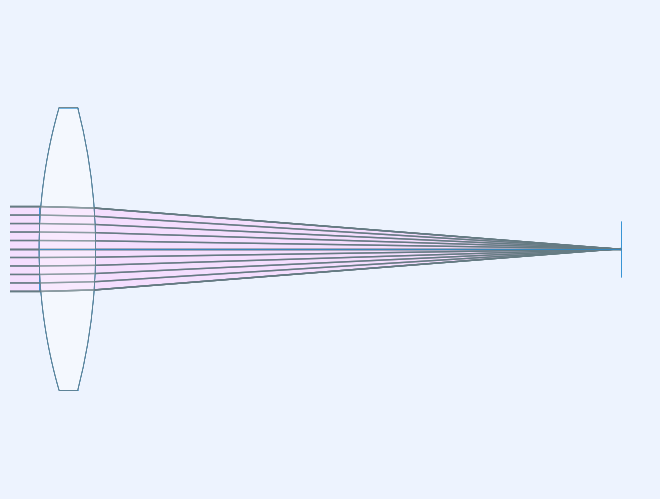

In [12]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_ray_fans=True, is_dark=False).plot()

# Geometrical MTF over focus, azimuth and spatial frequency

In [13]:
def perfect_MTF(nu, nu_cutoff):
    """ Circular pupil, on-axis """
    phi = np.arccos(cos_phi:=(nu/nu_cutoff))
    MTF_nu = (2/np.pi)*(phi - np.sin(phi)*cos_phi)
    return MTF_nu

In [14]:
f0 = osp['fov'].fields[0]
wvl = osp['wvls'].central_wvl

In [15]:
ctr_ray_result = trace_ray(opm, [0., 0.], fld, wvl)
ctr_ray = ctr_ray_result.pkg.ray

img_offset = ctr_ray[-1][0]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

In [16]:
pixel_size = 0.001
num_img_samples = 250
img_half_width = pixel_size * (num_img_samples//2)
grid_width=128
print(f"{pixel_size=:6.4f},  {img_half_width=:6.3f}")

pixel_size=0.0010,  img_half_width= 0.125


In [17]:
efl = ar['parax_data'].fod.efl
ht_per_deg = np.tan(np.pi/180)*efl
print(f"{efl=:6.3f},  {ht_per_deg=:6.3f}")

efl=19.286,  ht_per_deg= 0.337


In [18]:
NA = abs(ar['parax_data'].fod.img_na)
wl_mm = opm.nm_to_sys_units(osp['wvls'].central_wvl)
nu_cutoff = 2 * NA / wl_mm
print(f"{NA=:6.4f},  {wl_mm=:8.6f},  {nu_cutoff=:6.1f}")

NA=0.0778,  wl_mm=0.000546,  nu_cutoff= 284.9


In [19]:
cycles_per_deg_lite = [.1, 5., 10., 15., 20.]
cycles_per_deg_dense = [.1, .5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 
                        11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21.]
img_freqs = [c/ht_per_deg for c in cycles_per_deg_dense]

In [20]:
MTF_ideal = [perfect_MTF(nu, nu_cutoff) for nu in img_freqs]

In [21]:
foc_lite = np.arange(-.125, 1.125, .375)
foc_dense = np.arange(-.25, 1.25, .125)
foc_list = foc_dense

## Define the raylist

Sample the pupil using a quasi-random number generator using a square to circle mapping

In [22]:
r2g = (sampler.create_generator, (sampler.R_2_quasi_random_generator, grid_width**2),
       dict(mapper=sampler.concentric_sample_disk))
gMTF_list = analyses.RayList(opm, pupil_gen=r2g, clip_rays=True, f=fld, wl=wvl, foc=0.0, image_pt_2d=on_axis_pt)

## Loop over focus, slice and frequency

In [23]:
foci = []
for foc in foc_list:
    gMTF_list.foc = foc
    gMTF_list.update_data(build='refocus')
    slices = []
    for i in range(2):
        xy_data = gMTF_list.ray_abr[i]
        xy_hist, xy_bin_edges = np.histogram(xy_data, bins=num_img_samples, 
                                             range=(-img_half_width, img_half_width))
        LSF = xy_hist/xy_hist.max()
        bin_cntrs = (xy_bin_edges[:-1] + xy_bin_edges[1:])/2
        mtf = []
        phase = []
        for nu in img_freqs:
            exp_arg = 2*np.pi*nu*bin_cntrs
            A_cos_x = LSF * np.cos(exp_arg)
            A_sin_x = LSF * np.sin(exp_arg)
            
            A_cos = pixel_size*np.sum(A_cos_x)
            A_sin = pixel_size*np.sum(A_sin_x)
            A_sum = pixel_size*np.sum(LSF)
            
            A_c = A_cos/A_sum
            A_s = A_sin/A_sum
            
            mtf.append(MTF := np.hypot(A_c, A_s))
            phase.append(tan_phi := A_s/A_c)
        slices.append((mtf, phase))
    foci.append(slices)

### plot MTF vs frequency

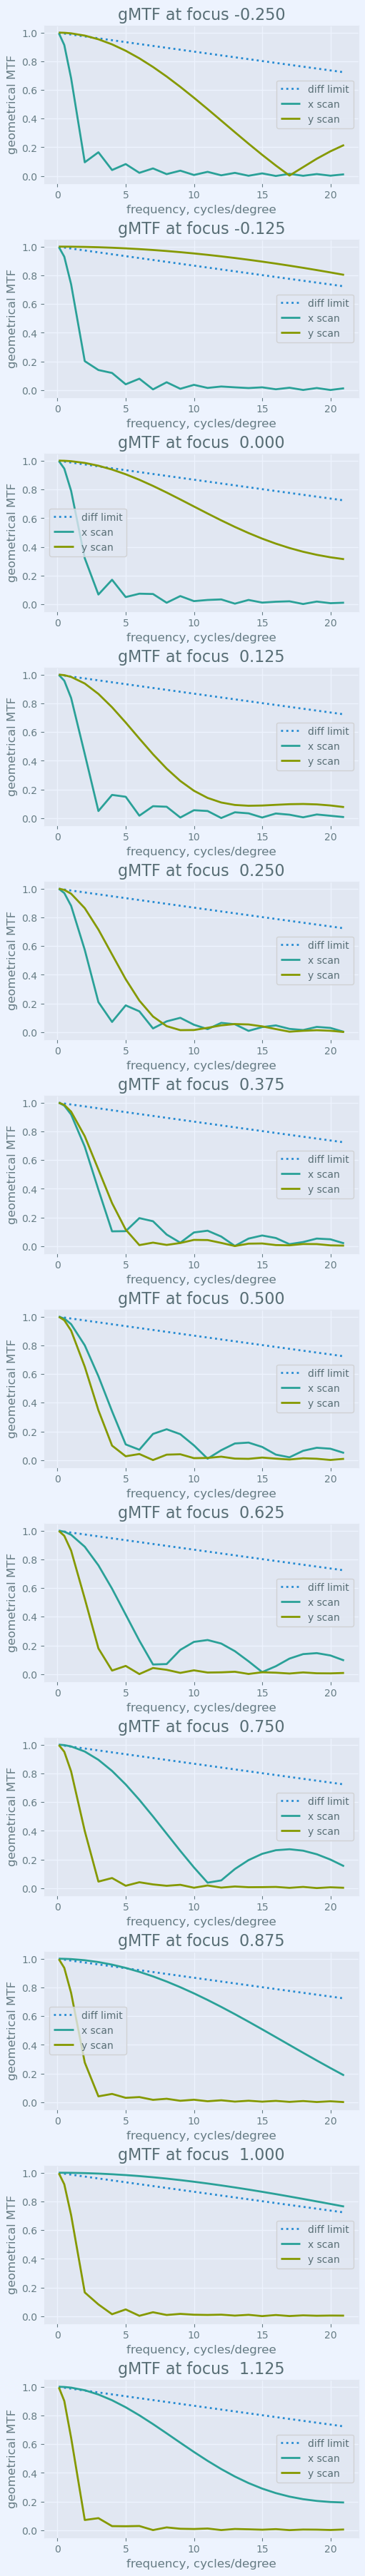

In [24]:
i_foc = 1
fig, ax = plt.subplots(len(foci),1, figsize=(5, 3*len(foci)), layout="constrained")             # Create a figure containing a single Axes.
# Plot some data on the Axes.
for i_foc in range(len(foci)):
    ax[i_foc].plot(cycles_per_deg_dense, MTF_ideal, label='diff limit', linestyle='dotted')
    ax[i_foc].plot(cycles_per_deg_dense, foci[i_foc][0][0], label='x scan')
    ax[i_foc].plot(cycles_per_deg_dense, foci[i_foc][1][0], label='y scan')
    ax[i_foc].set_xlabel('frequency, cycles/degree')
    ax[i_foc].set_ylabel('geometrical MTF')
    ax[i_foc].set_title(f"gMTF at focus {foc_dense[i_foc]:6.3f}")
    ax[i_foc].legend()

### plot MTF vs focus

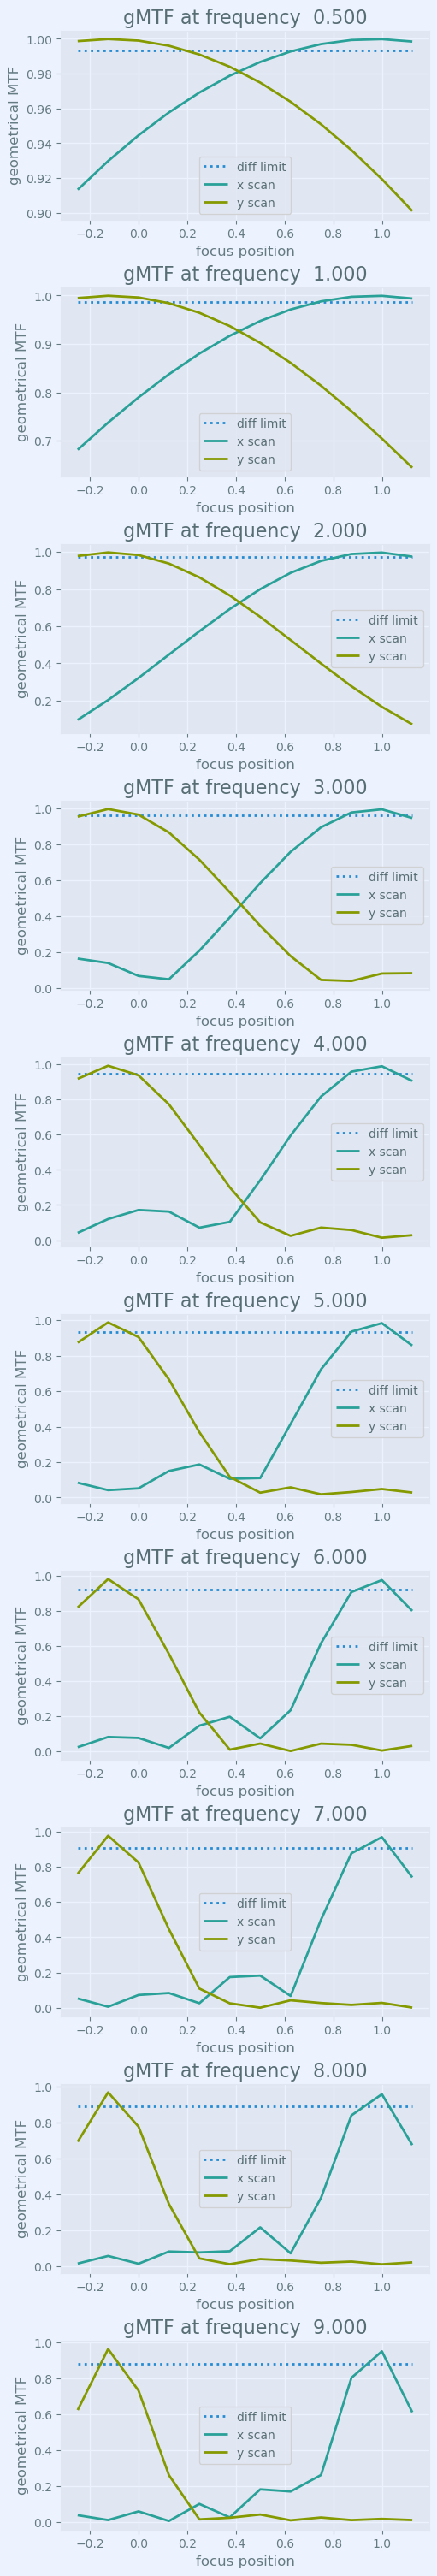

In [25]:
freq_list = cycles_per_deg_dense[1:11]
MTF_ideal_sub = MTF_ideal[1:11]
fig_tf, ax_tf = plt.subplots(len(freq_list),1, figsize=(5, 3*len(freq_list)), layout="constrained")             # Create a figure containing a single Axes.
# Plot some data on the Axes.
for i in range(len(freq_list)):
    i_freq = cycles_per_deg_dense.index(freq_list[i])
    ideal_thru_foc = [MTF_ideal[i_freq] for i_foc in foc_list]
    x_thru_foc = [foci[i_foc][0][0][i_freq] for i_foc in range(len(foc_list))]
    y_thru_foc = [foci[i_foc][1][0][i_freq] for i_foc in range(len(foc_list))]
    ax_tf[i].plot(foc_list, ideal_thru_foc, label='diff limit', linestyle='dotted')
    ax_tf[i].plot(foc_list, x_thru_foc, label='x scan')
    ax_tf[i].plot(foc_list, y_thru_foc, label='y scan')
    ax_tf[i].set_xlabel('focus position')
    ax_tf[i].set_ylabel('geometrical MTF')
    ax_tf[i].set_title(f"gMTF at frequency {freq_list[i]:6.3f}")
    ax_tf[i].legend()